In [1]:
# import the necessary packages
from imutils import paths
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os
import time

# adding audio part
from ffpyplayer.player import MediaPlayer


# Pickle
In Python, we use pickle to serialize (deserialize) an object structure into (from) a byte stream.  **(similar to object serialization in Java!)**)

### In my project:
1. **embeddings.pickle:** A serialized facial embeddings file. Embeddings have been computed for every face in the dataset and are stored in this file.
2. **le.pickle:** Our label encoder. Contains the name labels for the people that our model can recognize.
3. **recognizer.pickle:** Our Linear Support Vector Machine (SVM) model. This is a machine learning model rather than deep learning model and it is responsible for actually recognizing faces.

What are face Embeddings?
By creating face embeddings you are converting a face image into numerical data. That data is then represented as a vector in a latent semantic space. The closer the embeddings are to each other in the latent space, the more likely they are of the same person.

We’ll review this file in Step #1 which is responsible for using a deep learning feature extractor to generate a 128-D vector describing a face (we are using 128-Demonsional vector because the popular FaceNet is using that). All faces in our dataset will be passed through the neural network to generate embeddings.



# Deep Learning Models
1. **res10_300x300_ssd_iter_140000.caffemodel** - a pre-trained Caffe deep learning model provided by OpenCV to detect faces. This model detects and localizes faces in an image. 
2. **128-D facial embeddings: (2 options)**.
    * ***openface_nn4.small2.v1.t7** - A Torch deep learning model which produces the 128-D facial embeddings. We’ll be using this deep learning model in Steps #1, #2, and #3.
    * ***face_recognition using dlib** -  It‘s a landmark’s facial detector with pre-trained models which produce the 128-D facial embeddings with more **accuracy!!!**


3. **train_model.py** - Our Linear SVM (Support Vectors Machine) model will be trained by this script in Step #2. We’ll detect faces, extract embeddings, and fit our SVM model to the embeddings data.

# Results:

<div>
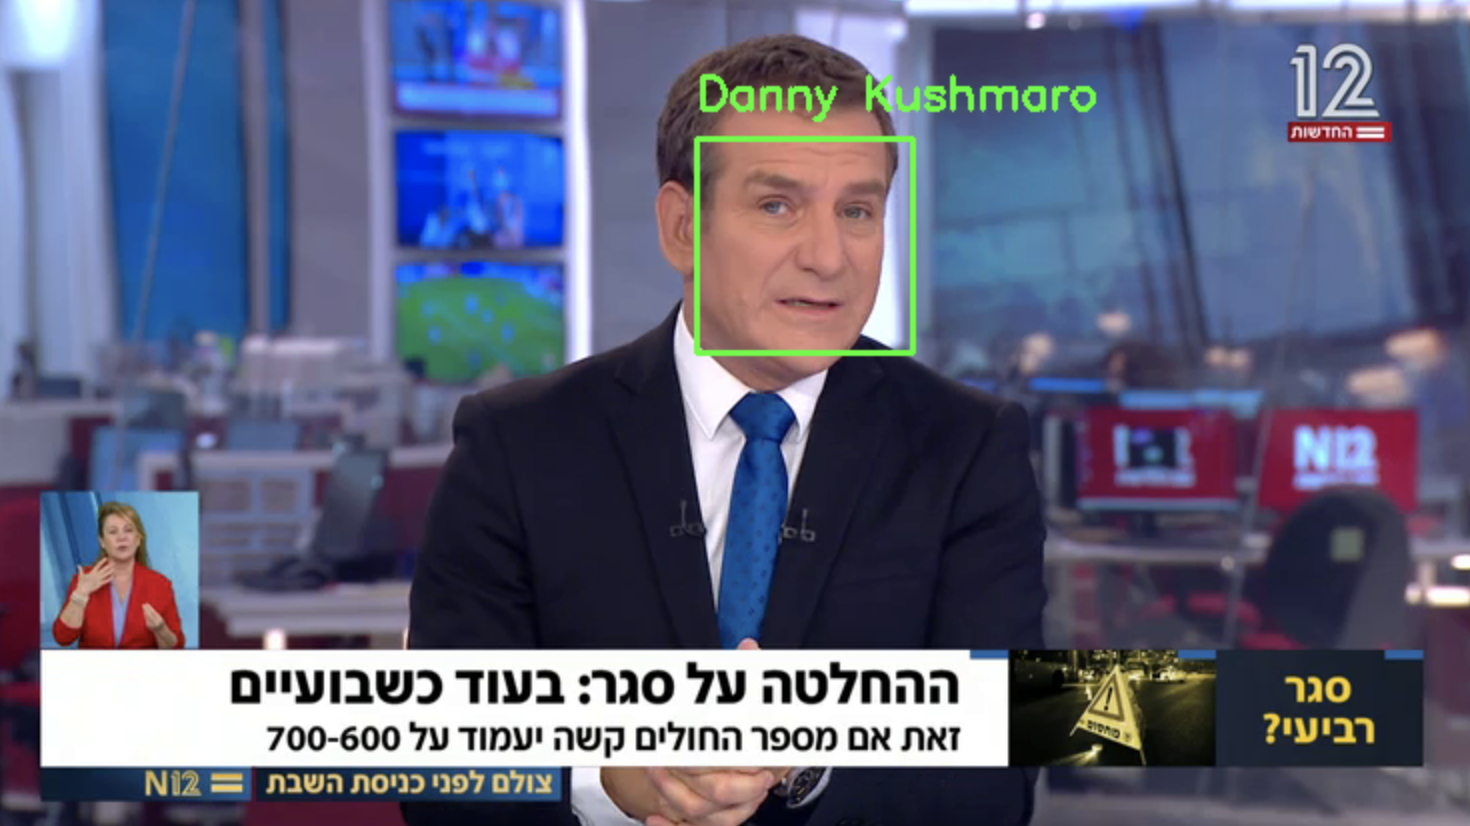
</div>



<div>
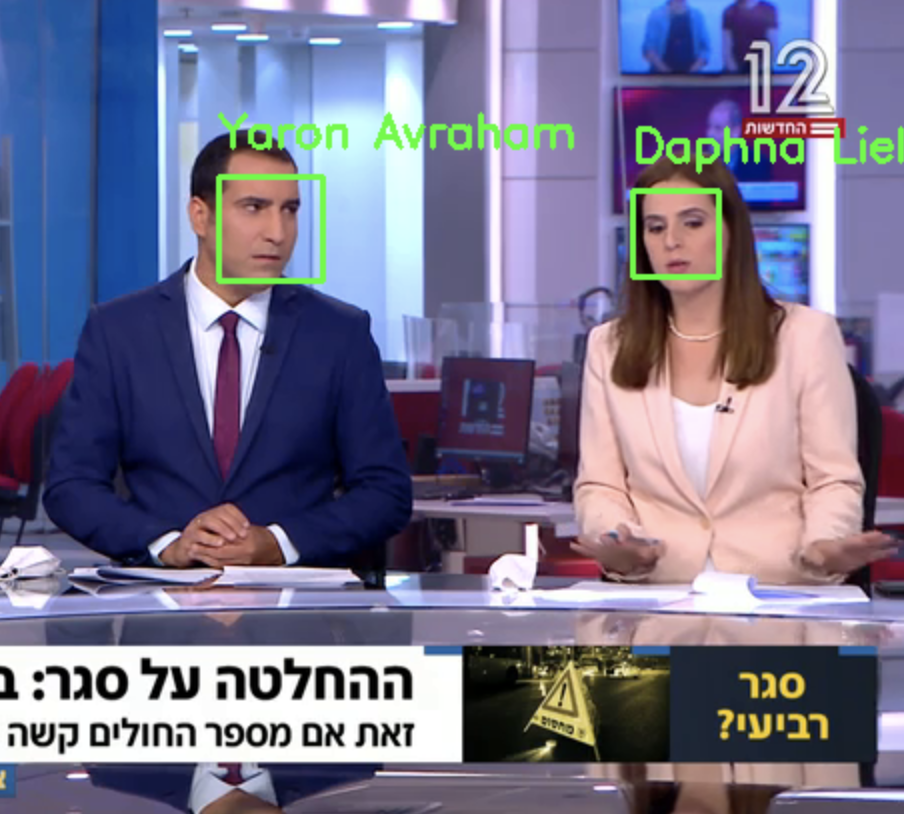
</div>





# *-----------------------------------------------------------------------------------------*
NOTICE: In the next code files with arguments, if "embedding_model" isn't recognise, delete it from the ap.add arguments and instead write
embedder = cv2.dnn.readNetFromTorch('args["embedding_model"]')
use the following line to direct path:
embedder = cv2.dnn.readNetFromTorch("openface_nn4.small2.v1.t7")


# Step #1: Extract embeddings from face dataset


alternative option with arguments are on extract_embeddings.py

## option 1 (faster encoding better for cpu)


In [ ]:
# import the necessary packages
import imutils
from imutils import paths
import numpy as np
import argparse
import pickle
import cv2
import os


# load our serialized face detector from disk
print("[INFO] loading face detector...")
protoPath = "face_detection_model/deploy.prototxt"
modelPath = "face_detection_model/res10_300x300_ssd_iter_140000.caffemodel"

detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# load our serialized face embedding model from disk
print("[INFO] loading face recognizer...")
embedder = cv2.dnn.readNetFromTorch("openface_nn4.small2.v1.t7")

# grab the paths to the input images in our dataset
print("[INFO] quantifying faces...")
imagePaths = list(paths.list_images("dataset3"))

#alternative to the args default input
confidenceSafe = 0.5

# initialize our lists of extracted facial embeddings and
# corresponding people names
knownEmbeddings = []
knownNames = []

# initialize the total number of faces processed
total = 0

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the person name from the image path
    name = imagePath.split(os.path.sep)[-2]
    picNumber = imagePath.split(os.path.sep)[-1]
    print("[INFO] processing image {}/{}".format(i + 1, len(imagePaths)) + " of {}".format(name) + " PicName {}".format(picNumber))

    # load the image, resize it to have a width of 600 pixels (while
    # maintaining the aspect ratio), and then grab the image
    # dimensions
    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]

    # construct a blob from the image
    imageBlob = cv2.dnn.blobFromImage(
    cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0), swapRB=False, crop=False)

    # apply OpenCV's deep learning-based face detector to localize
    # faces in the input image
    detector.setInput(imageBlob)
    detections = detector.forward()

    # ensure at least one face was found
    if len(detections) > 0:
        # we're making the assumption that each image has only ONE
        # face, so find the bounding box with the largest probability
        i = np.argmax(detections[0, 0, :, 2])
        confidence = detections[0, 0, i, 2]

        # ensure that the detection with the largest probability also
        # means our minimum probability test (thus helping filter out
        # weak detections)
           
        if confidence > confidenceSafe:
            # compute the (x, y)-coordinates of the bounding box for
            # the face
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # extract the face ROI and grab the ROI dimensions
            face = image[startY:endY, startX:endX]
            (fH, fW) = face.shape[:2]
            
            # Show the successfull faces cut by 
            #cv2.imshow("video",face)
            #cv2.waitKey(1)
            
            
            # ensure the face width and height are sufficiently large
            if fW < 20 or fH < 20:
                continue

            # construct a blob for the face ROI, then pass the blob
            # through our face embedding model to obtain the 128-d
            # quantification of the face
            faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96), (0, 0, 0), swapRB=True, crop=False)
            embedder.setInput(faceBlob)
            vec = embedder.forward()

            # add the name of the person + corresponding face
            # embedding to their respective lists
            knownNames.append(name)
            knownEmbeddings.append(vec.flatten())
            total += 1
            
            
# For showing the faces            
#cv2.waitKey(1)
#cv2.destroyAllWindows()


# dump the facial embeddings + names to disk
print("[INFO] serializing {} encodings...".format(total))
data = {"embeddings": knownEmbeddings, "names": knownNames} # Saving the embeddings images and the name.
f = open("output/embeddings.pickle", "wb")
f.write(pickle.dumps(data))
f.close()
print("[INFO] Done!")



# Step 1-Option 2 for embeddings: Encoding faces using dlib libary (more accurate but slower for preprocessing)
### ATTENTION FOR ME: RUN THIS CODE ON THE TERMINAL FOR SOMEREASON THE ENCODING STOPS IN THE MIDDLE IN THE JUPYTER NOTEBOOK.


## dlib libary 
What is Dlib?
It‘s a landmark’s facial detector with pre-trained models, the dlib is used to estimate the location of 68 coordinates (x, y) that map the facial points on a person’s face like image below.

<div>
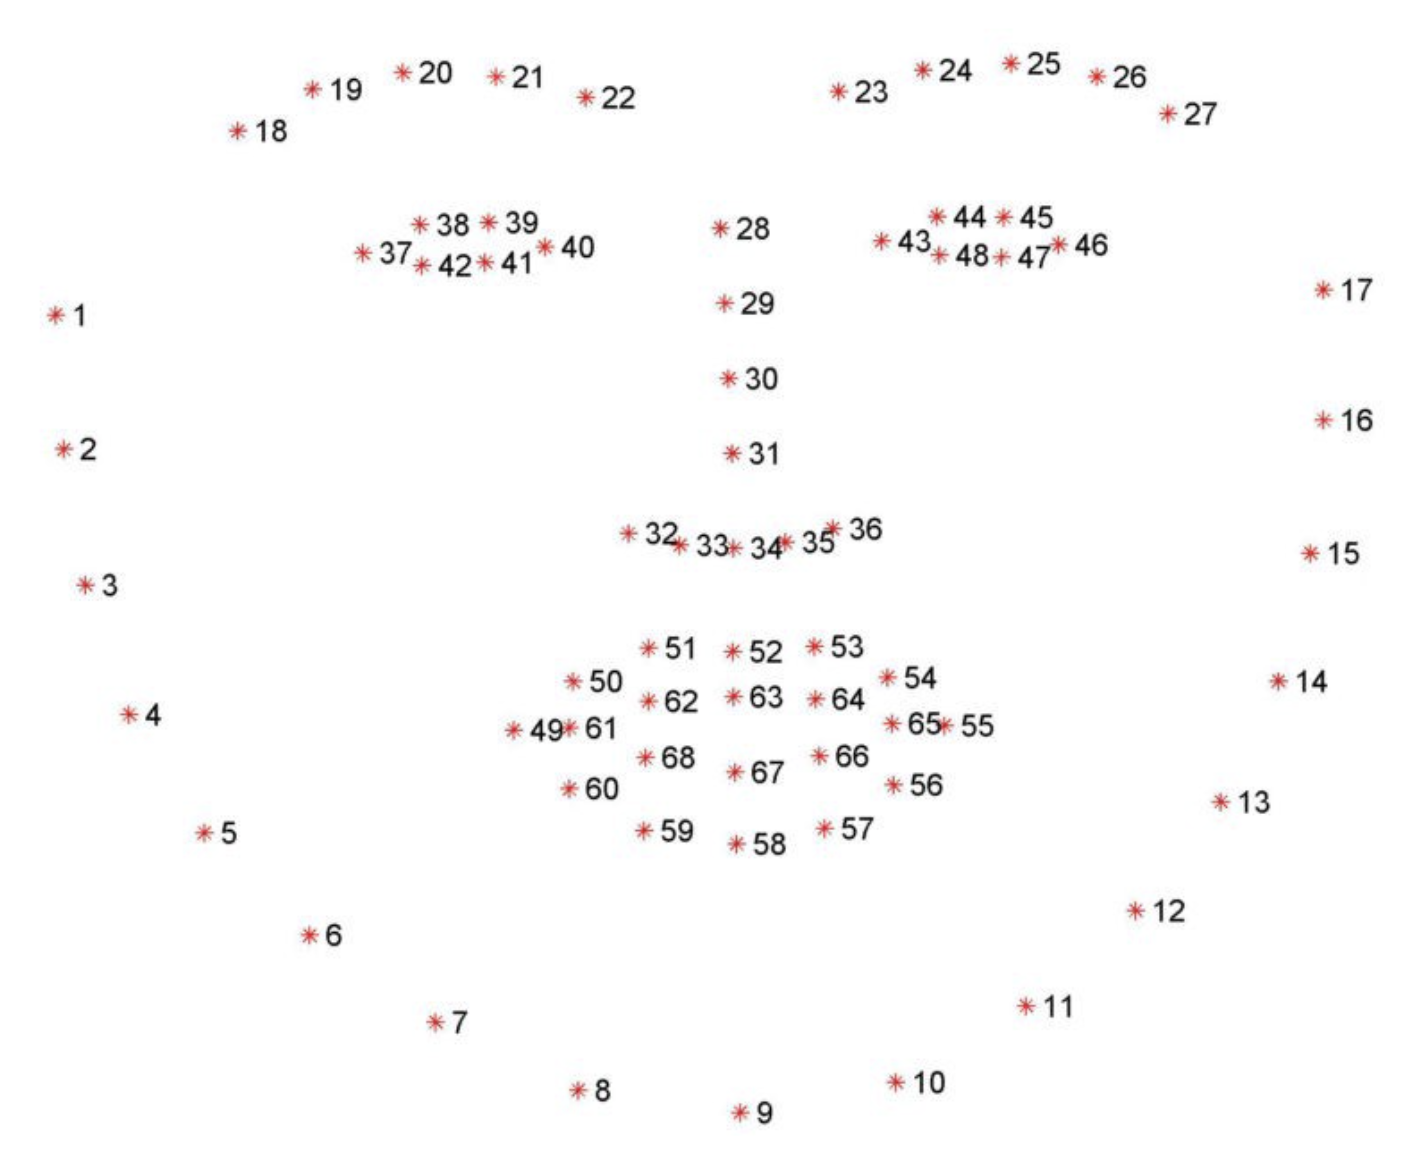
</div>

OpenCV orders color channels in BGR, but the dlib actually expects RGB so we convert it.
For implemention we use face_recognition module that uses dlib. 
 
We find/localize the faces of the pictures in a list of face boxes faces by using the command **face_recognition.face_locations(imageRGB,model)**.

image - in RGB format.

model - either CNN or HOG:
* The CNN method is more accurate but slower (Better to use it with GPU). 
* HOG is faster but less accurate. (if you have only CPU you should use the 'hog' because the cnn is too slow. GPU is faster here too)

***I am using a macbook so I use the HOG model in this project.***

HOG (The histogram of oriented gradients) - is a feature descriptor used in computer vision and image processing for the purpose of object detection. The technique counts occurrences of gradient orientation in localized portions of an image. 



***Important Performance Note:*** The CNN face recognizer should only be used in real-time (video/webcam) if you are working with a GPU (you can use it with a CPU, but expect less than 0.5 FPS which makes for a choppy video). Alternatively (you are using a CPU), you should use the HoG method (or even OpenCV Haar cascades) and expect adequate speeds.

In [ ]:
from imutils import paths
import face_recognition
import argparse
import pickle
import cv2
import os



# grab the paths to the input images in our dataset
print("[INFO] quantifying faces...")
imagePaths = list(paths.list_images("dataset"))

# initialize the list of known encodings and known names
knownEncodings = []
knownNames = []



# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the person name from the image path
    print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))
    name = imagePath.split(os.path.sep)[-2]

    # load the input image and convert it from BGR (OpenCV ordering)
    # to dlib ordering (RGB)
    image = cv2.imread(imagePath)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # detect the (x, y)-coordinates of the bounding boxes
    # corresponding to each face in the input image
    boxes = face_recognition.face_locations(rgb,model="hog")

    # compute the facial embedding for the face
    encodings = face_recognition.face_encodings(rgb, boxes)

    # loop over the encodings
    for encoding in encodings:
        # add each encoding + name to our set of known names and
        # encodings
        knownEncodings.append(encoding)
        knownNames.append(name)
    
    
#dump the facial encodings + names to disk
print("[INFO] serializing encodings...")
data = {"embeddings": knownEncodings, "names": knownNames}
f = open("output/embeddings_big.pickle", "wb")
f.write(pickle.dumps(data))
f.close()    

# Step 2: Training Model

alternative option with arguments are on train_model.py

In [7]:
# USAGE
# python train_model.py --embeddings output/embeddings.pickle \
# --recognizer output/recognizer.pickle --le output/le.pickle

# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import argparse
import pickle


# load the face embeddings
print("[INFO] loading face embeddings...")
data = pickle.loads(open("output/embeddings.pickle", "rb").read())

# encode the labels
print("[INFO] encoding labels...")
le = LabelEncoder()
labels = le.fit_transform(data["names"])


# train the model used to accept the 128-d embeddings of the face and
# then produce the actual face recognition
print("[INFO] training model...")
# We use linear kernel so we don't need to set the gamma. we dont know which C is better.
#recognizer = SVC(C=1.0, kernel="linear", probability=True)
recognizer = SVC(C=20, kernel="linear", probability=True)

# FOR OPTION 1
#recognizer.fit(data["embeddings"], labels)
recognizer.fit(data["embeddings"], labels)

# write the actual face recognition model to disk
f = open("output/recognizer.pickle", "wb")
f.write(pickle.dumps(recognizer))
f.close()

# write the label encoder to disk
f = open("output/le.pickle", "wb")
f.write(pickle.dumps(le))
f.close()
print("[INFO] Done!")


[INFO] loading face embeddings...
[INFO] encoding labels...
[INFO] training model...
[INFO] Done!


# Step 3: Detect Faces in Video/Img

Option 1 (using the openface model + caffemodel)

In [3]:
# import the necessary packages
from imutils import paths
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os
import time
import face_recognition
# adding audio part
from ffpyplayer.player import MediaPlayer

# load our serialized face detector from disk
print("[INFO] loading face detector...")
# set paths in convinient way
protoPath = os.path.sep.join(["face_detection_model", "deploy.prototxt"])
modelPath = os.path.sep.join(["face_detection_model",
                              "res10_300x300_ssd_iter_140000.caffemodel"])

detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# video path
#video_path = "12-6-2021-news.mp4"
video_path = "SegerArgument.mp4"


# load our serialized face embedding model from disk
print("[INFO] loading face recognizer...")
embedder = cv2.dnn.readNetFromTorch("openface_nn4.small2.v1.t7")

# load the actual face recognition model along with the label encoder
recognizer = pickle.loads(open("output/recognizer.pickle", "rb").read())
le = pickle.loads(open("output/le.pickle", "rb").read())

# initialize the video stream, then allow the camera sensor to warm up
print("[INFO] starting video stream...")
##vs = VideoStream(src=0).start()


# Audio Player
    #***RIGHT NOW THE AUDIO DOESN'T STOP AND IT TOO FAST FOR THE VIDEO SO IT COMMENTED***

#player = MediaPlayer(video_path)


# frame catcher
cap = cv2.VideoCapture(video_path)
ret, frame1 = cap.read()

#time.sleep(2.0)

# start the FPS throughput estimator
##fps = FPS().start()

# loop over frames from the video file stream
while True:
    # grab the frame from the threaded video stream
    ret, frame = cap.read()
    
    # grab the current audio frame from the video
        #***RIGHT NOW THE AUDIO DOESN'T STOP AND IT TOO FAST FOR THE VIDEO SO IT COMMENTED***

        #audio_frame, val = player.get_frame()

    # The shape of an image is accessed by img.shape.
    # It returns a tuple of the number of rows, columns, and channels (if the image is color):
    h1, w1 , _ = frame.shape
    #frame = cv2.resize(frame,(h1,600))

    # resize the frame to have a width of 600 pixels (while
    # maintaining the aspect ratio), and then grab the image
    # dimensions
    h, w , _ = frame.shape

    # construct a blob from the image
    imageBlob = cv2.dnn.blobFromImage(
        cv2.resize(frame, (300, 300)), 1.0, (300, 300),
        (104.0, 177.0, 123.0), swapRB=False, crop=False)

    # apply OpenCV's deep learning-based face detector to localize
    # faces in the input image
    detector.setInput(imageBlob)
    detections = detector.forward()
    
    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the prediction
        confidence = detections[0, 0, i, 2]

        # filter out weak detections
        if confidence > 0.6:
            # compute the (x, y)-coordinates of the bounding box for
            # the face
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # extract the face ROI
            face = frame[startY:endY, startX:endX]
            (fH, fW) = face.shape[:2]

            # ensure the face width and height are sufficiently large
            if fW < 20 or fH < 20:
                continue

            # construct a blob for the face ROI, then pass the blob
            # through our face embedding model to obtain the 128-d
            # quantification of the face
            faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255,
                                             (96, 96), (0, 0, 0), swapRB=True, crop=False)
            embedder.setInput(faceBlob)
            vec = embedder.forward()

            # perform classification to recognize the face
            preds = recognizer.predict_proba(vec)[0]
            j = np.argmax(preds)
            proba = preds[j]
            name = le.classes_[j]
            # draw the bounding box of the face along with the
            # associated probability
            if proba * 100 > 99:
                # TEXT WITH ACCURACY
                text = "{}: {:.2f}%".format(name, proba * 100)
            
            # TEXT WITHOUT ACCUARCY
            text = "{}".format(name)

            
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(frame, (startX, startY), (endX, endY),
                          (0, 0, 255), 2)
            cv2.putText(frame, text, (startX, y),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

    # update the FPS counter
    #fps.update()
    
    
    #return to original size
    #frame = cv2.resize(frame,(2000,1000))

    
    if cv2.waitKey(15) & 0xFF == ord("q"):
            break
    
    #***RIGHT NOW THE AUDIO DOESN'T STOP AND IT TOO FAST FOR THE VIDEO SO IT COMMENTED***
        #if val != 'eof' and audio_frame is not None:
                # play audio
            #img, t = audio_frame

    cv2.imshow("Frame", frame)

            
    # show the output frame
    ##key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, break from the loop
    ##if key == ord("q"):
      #  break

# stop the timer and display FPS information
#fps.stop()
#print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
#print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

# do a bit of cleanup
cv2.destroyAllWindows()
cv2.waitKey(1)
cap.release()
print("[INFO] WELL DONE!")

[INFO] loading face detector...
[INFO] loading face recognizer...
[INFO] starting video stream...
[INFO] WELL DONE!


# Step 3:
## Option 2
working faster for GPU

In [1]:
# import the necessary packages
from imutils import paths
import face_recognition
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os
import time

# video path
#video_path = "12-6-2021-news.mp4"
video_path = "SegerArgument.mp4"
data = pickle.loads(open("output/embeddings_big.pickle", "rb").read())

# Audio Player
    #***RIGHT NOW THE AUDIO DOESN'T STOP AND IT TOO FAST FOR THE VIDEO SO IT COMMENTED***
    
#player = MediaPlayer(video_path)
# initialize the video stream, then allow the camera sensor to warm up
print("[INFO] starting video stream...")
# frame catcher
cap = cv2.VideoCapture(video_path)

# loop over frames from the video file stream
while True:
    start0 = time.time()
    # grab the frame from the threaded video stream
    ret, frame = cap.read()
    
    # convert the input frame from BGR to RGB then resize it to have
    # a width of 750px (to speedup processing)
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #rgb = imutils.resize(frame, width=600)
    r = frame.shape[1] / float(rgb.shape[1])

    # detect the (x, y)-coordinates of the bounding boxes
    # corresponding to each face in the input frame, then compute
    # the facial embeddings for each face
    start = time.time()
    boxes = face_recognition.face_locations(rgb)
    encodings = face_recognition.face_encodings(rgb, boxes)
    names = []
    end = time.time()
    print("The time for face_locations and face_encodings is: {} ".format(end-start))
    lala = False
    
    # loop over the facial embeddings
    for encoding in encodings:
        # attempt to match each face in the input image to our known
        # encodings
        start2 = time.time()
        matches = face_recognition.compare_faces(data["embeddings"],
            encoding)
        end2 = time.time()
        print("The time for compare_faces is: {} ".format(end2-start2))
        name = "Unknown"

        # check to see if we have found a match
        if True in matches:
            start1 = time.time()
            lala = True
            # find the indexes of all matched faces then initialize a
            # dictionary to count the total number of times each face
            # was matched
            matchedIdxs = [i for (i, b) in enumerate(matches) if b]
            counts = {}
    
            # loop over the matched indexes and maintain a count for
            # each recognized face face
            for i in matchedIdxs:
                name = data["names"][i]
                counts[name] = counts.get(name, 0) + 1

            # determine the recognized face with the largest number
            # of votes (note: in the event of an unlikely tie Python
            # will select first entry in the dictionary)
            name = max(counts, key=counts.get)
            # update the list of names
        names.append(name)
    
     #loop over the recognized faces
    for ((top, right, bottom, left), name) in zip(boxes, names):
        # rescale the face coordinates
        top = int(top * r)
        right = int(right * r)
        bottom = int(bottom * r)
        left = int(left * r)

        # draw the predicted face name on the image
        cv2.rectangle(frame, (left, top), (right, bottom),
            (0, 255, 0), 2)
        y = top - 15 if top - 15 > 15 else top + 15
        cv2.putText(frame, name, (left, y), cv2.FONT_HERSHEY_SIMPLEX,
        0.75, (0, 255, 0), 2)
        
    if lala:
        end1 = time.time()
        print("The time for rectangles is: {} ".format(end1-start1))
    lala = False
    
    # grab the current audio frame from the video
        #***RIGHT NOW THE AUDIO DOESN'T STOP AND IT TOO FAST FOR THE VIDEO SO IT COMMENTED***

        #audio_frame, val = player.get_frame()

    if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    
    #***RIGHT NOW THE AUDIO DOESN'T STOP AND IT TOO FAST FOR THE VIDEO SO IT COMMENTED***
        #if val != 'eof' and audio_frame is not None:
                # play audio
            #img, t = audio_frame
   
    cv2.imshow("Frame", frame)
    end0 = time.time()
    print(int(1/(end0-start0)))
    
            
# do a bit of cleanup
cv2.destroyAllWindows()
cv2.waitKey(1)
cap.release()
print("[INFO] WELL DONE!")

[INFO] starting video stream...
The time for face_locations and face_encodings is: 0.19527292251586914 
The time for compare_faces is: 0.0346376895904541 
The time for compare_faces is: 0.030995845794677734 
The time for compare_faces is: 0.030133962631225586 
The time for rectangles is: 0.0020999908447265625 
2
The time for face_locations and face_encodings is: 0.1940767765045166 
The time for compare_faces is: 0.024834156036376953 
The time for compare_faces is: 0.02691197395324707 
The time for compare_faces is: 0.028670072555541992 
The time for rectangles is: 0.002015829086303711 
2
The time for face_locations and face_encodings is: 0.2355329990386963 
The time for compare_faces is: 0.03406095504760742 
The time for compare_faces is: 0.033101797103881836 
The time for compare_faces is: 0.027984142303466797 
The time for rectangles is: 0.002042055130004883 
2
The time for face_locations and face_encodings is: 0.19635391235351562 
The time for compare_faces is: 0.026241064071655273 

The time for face_locations and face_encodings is: 0.1921710968017578 
The time for compare_faces is: 0.02515101432800293 
The time for compare_faces is: 0.026583194732666016 
The time for compare_faces is: 0.02608013153076172 
The time for rectangles is: 0.0019881725311279297 
3
The time for face_locations and face_encodings is: 0.19142889976501465 
The time for compare_faces is: 0.025142908096313477 
The time for compare_faces is: 0.025424718856811523 
The time for compare_faces is: 0.02698683738708496 
The time for rectangles is: 0.0020508766174316406 
3
The time for face_locations and face_encodings is: 0.1960299015045166 
The time for compare_faces is: 0.0277860164642334 
The time for compare_faces is: 0.029397964477539062 
The time for compare_faces is: 0.027523040771484375 
The time for rectangles is: 0.002076864242553711 
3
The time for face_locations and face_encodings is: 0.15584778785705566 
The time for compare_faces is: 0.0267181396484375 
The time for rectangles is: 0.003

In [ ]:
import pickle

data = pickle.loads(open("output/embeddings_big.pickle", "rb").read())

for i, j in enumerate(data["names"]):
    if j == 'irrelevant':
        data["names"].pop(i)
        data["embeddings"].pop(i)
        

f = open("output/embeddingswithoutr.pickle", "wb")
f.write(pickle.dumps(data))
f.close()
print("done")

In [ ]:
# import the necessary packages
from imutils import paths
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os
import time
import face_recognition
# adding audio part
from ffpyplayer.player import MediaPlayer

# load our serialized face detector from disk
print("[INFO] loading face detector...")
# set paths in convinient way
protoPath = os.path.sep.join(["face_detection_model", "deploy.prototxt"])
modelPath = os.path.sep.join(["face_detection_model",
                              "res10_300x300_ssd_iter_140000.caffemodel"])

detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# video path
#video_path = "12-6-2021-news.mp4"
video_path = "SegerArgument.mp4"


# load our serialized face embedding model from disk
print("[INFO] loading face recognizer...")
embedder = cv2.dnn.readNetFromTorch("openface_nn4.small2.v1.t7")

# load the actual face recognition model along with the label encoder
recognizer = pickle.loads(open("output/recognizer.pickle", "rb").read())
le = pickle.loads(open("output/le.pickle", "rb").read())

# initialize the video stream, then allow the camera sensor to warm up
print("[INFO] starting video stream...")
##vs = VideoStream(src=0).start()


# Audio Player
    #***RIGHT NOW THE AUDIO DOESN'T STOP AND IT TOO FAST FOR THE VIDEO SO IT COMMENTED***

#player = MediaPlayer(video_path)


# frame catcher
cap = cv2.VideoCapture(video_path)
ret, frame1 = cap.read()

#time.sleep(2.0)

# start the FPS throughput estimator
##fps = FPS().start()

# loop over frames from the video file stream
while True:
    # grab the frame from the threaded video stream
    ret, frame = cap.read()
   
    # Find all the faces in the test image using the default HOG-based model
    face_locations = face_recognition.face_locations(frame)
    no = len(face_locations)
    print("Number of faces detected: ", no)

    # Predict all the faces in the test image using the trained classifier
    print("Found:")
    for i in range(no):
        test_image_enc = face_recognition.face_encodings(frame)[i]
        name = recognizer.predict([test_image_enc])[0]
        print(name)
    
    
    #return to original size
    #frame = cv2.resize(frame,(2000,1000))

    
    if cv2.waitKey(15) & 0xFF == ord("q"):
            break
    
    #***RIGHT NOW THE AUDIO DOESN'T STOP AND IT TOO FAST FOR THE VIDEO SO IT COMMENTED***
        #if val != 'eof' and audio_frame is not None:
                # play audio
            #img, t = audio_frame

    cv2.imshow("Frame", frame)

            
    # show the output frame
    ##key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, break from the loop
    ##if key == ord("q"):
      #  break

# stop the timer and display FPS information
#fps.stop()
#print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
#print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

# do a bit of cleanup
cv2.destroyAllWindows()
cv2.waitKey(1)
cap.release()
print("[INFO] WELL DONE!")

[INFO] loading face detector...
[INFO] loading face recognizer...
[INFO] starting video stream...
Number of faces detected:  3
Found:
5
4
0
Number of faces detected:  3
Found:
5
4
0
Number of faces detected:  3
Found:
5
4
0
Number of faces detected:  3
Found:
5
4
0
Number of faces detected:  3
Found:
5
4
0
Number of faces detected:  3
Found:
5
4
3
Number of faces detected:  3
Found:
5
4
0
Number of faces detected:  3
Found:
5
4
3
Number of faces detected:  3
Found:
5
4
3
Number of faces detected:  3
Found:
4
5
2
Number of faces detected:  3
Found:
5
4
0
Number of faces detected:  3
Found:
5
4
3
Number of faces detected:  3
Found:
5
4
0
Number of faces detected:  3
Found:
5
4
0
Number of faces detected:  3
Found:
5
4
0
Number of faces detected:  3
Found:
5
4
0
Number of faces detected:  3
Found:
5
4
0
Number of faces detected:  3
Found:
5
4
0
Number of faces detected:  3
Found:
5
4
3
Number of faces detected:  3
Found:
5
4
3
Number of faces detected:  3
Found:
5
4
3
Number of faces dete

# INPROGRESS

In [ ]:
# # Train multiple images per person
# # Find and recognize faces in an image using a SVC with scikit-learn

# """
# Structure:
#         <test_image>.jpg
#         <train_dir>/
#             <person_1>/
#                 <person_1_face-1>.jpg
#                 <person_1_face-2>.jpg
#                 .
#                 .
#                 <person_1_face-n>.jpg
#            <person_2>/
#                 <person_2_face-1>.jpg
#                 <person_2_face-2>.jpg
#                 .
#                 .
#                 <person_2_face-n>.jpg
#             .
#             .
#             <person_n>/
#                 <person_n_face-1>.jpg
#                 <person_n_face-2>.jpg
#                 .
#                 .
#                 <person_n_face-n>.jpg
# """

# import face_recognition
# from sklearn import svm
# import os
# import pickle
# import cv2
# import numpy as np
# import imutils
# # Training the SVC classifier

# # The training data would be all the face encodings from all the known images and the labels are their names


# # video path
# video_path = "12-6-2021-news.mp4"
# data = pickle.loads(open("output/embeddings_big.pickle", "rb").read())
# # load the actual face recognition model along with the label encoder
# recognizer = pickle.loads(open("output/recognizer.pickle", "rb").read())
# le = pickle.loads(open("output/le.pickle", "rb").read())

# # Audio Player
#     #***RIGHT NOW THE AUDIO DOESN'T STOP AND IT TOO FAST FOR THE VIDEO SO IT COMMENTED***
    
# #player = MediaPlayer(video_path)
# # initialize the video stream, then allow the camera sensor to warm up
# print("[INFO] starting video stream...")
# # frame catcher
# cap = cv2.VideoCapture(video_path)

# # Load the test image with unknown faces into a numpy array

# # loop over frames from the video file stream
# while True:
#     # grab the frame from the threaded video stream
#     ret, image = cap.read()
#     image = imutils.resize(image,width=250)

#     frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # Find all the faces in the test image using the default HOG-based model
#     face_locations = face_recognition.face_locations(frame)
#     no = len(face_locations)
#     print("Number of faces detected: ", no)

#     # Predict all the faces in the test image using the trained classifier
#     print("Found:")
#     for i in range(no):
#         test_image_enc = face_recognition.face_encodings(frame)[i]
#         name = recognizer.predict([test_image_enc])
#         j = np.argmax(name)
#         name = le.classes_[j]
#         print(name)
    
    
#     #return to original size
#     #frame = cv2.resize(frame,(2000,1000))

    
#     if cv2.waitKey(1) & 0xFF == ord("q"):
#             break
    
#     #***RIGHT NOW THE AUDIO DOESN'T STOP AND IT TOO FAST FOR THE VIDEO SO IT COMMENTED***
#         #if val != 'eof' and audio_frame is not None:
#                 # play audio
#             #img, t = audio_frame

#     cv2.imshow("Frame", image)

            
#     # show the output frame
#     ##key = cv2.waitKey(1) & 0xFF

#     # if the `q` key was pressed, break from the loop
#     ##if key == ord("q"):
#       #  break

# # stop the timer and display FPS information
# #fps.stop()
# #print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
# #print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

# # do a bit of cleanup
# cv2.destroyAllWindows()
# cv2.waitKey(1)
# cap.release()
# print("[INFO] WELL DONE!")



# Face alignment (Still in progress)


In [1]:
from imutils.face_utils import FaceAligner
# from imutils.face_utils import rect_to_bb
# import argparse
# import imutils
# import dlib
# import cv2


# # initialize dlib's face detector (HOG-based) and then create
# # the facial landmark predictor and the face aligner
# detector = dlib.get_frontal_face_detector()
# predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
# fa = FaceAligner(predictor, desiredFaceWidth=256)


# # load the input image, resize it, and convert it to grayscale
# image = cv2.imread("dataset/Dana Weiss/8.jpeg")
# image = imutils.resize(image, width=800)
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# # show the original input image and detect faces in the grayscale
# # image
# cv2.imshow("Input", image)
# rects = detector(gray, 2)


# # loop over the face detections
# for rect in rects:
#     # extract the ROI of the *original* face, then align the face
#     # using facial landmarks
#     (x, y, w, h) = rect_to_bb(rect)
#     faceOrig = imutils.resize(image[y:y + h, x:x + w], width=256)
#     faceAligned = fa.align(image, gray, rect)
#     # display the output images
#     cv2.imshow("Original", faceOrig)
#     cv2.imshow("Aligned", faceAligned)
#     cv2.waitKey(0)

# 

# 


#<div>
#<img src="attachment:image-2.png" width="800"/>
#</div>


#<div>
#<img src="attachment:image-3.png" width="300"/>
#</div>



